In [7]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [1]:
class LandScape():

    def __init__(self, N, K, K_within, K_between):
        self.N = N
        self.K = K
        self.K_within = K_within
        self.K_between = K_between
        self.IM, self.IM_dic = None, None
        self.FC = None
        self.cache = {}
        self.cog_cache = {}

    def create_influence_matrix(self):
        IM = np.eye(self.N)
        if self.K_within is None:
            for i in range(self.N):
                probs = [1 / (self.N - 1)] * i + [0] + [1 / (self.N - 1)] * (self.N - 1 - i)
                ids = np.random.choice(self.N, self.K, p=probs, replace=False)
                for index in ids:
                    IM[i][index] = 1
        else:
            for i in range(self.N):
                if i // (self.N // 2) < 1:
                    within = [j for j in range(self.N // 2)]
                    between = [j for j in range(self.N // 2, self.N)]
                    probs = [1 / (self.N // 2 - 1)] * i + [0] + [1 / (self.N // 2 - 1)] * (self.N // 2 - 1 - i)
                    ids_within = np.random.choice(within, self.K_within, p=probs, replace=False)
                    ids_between = np.random.choice(between, self.K_between, replace=False)
                    for index in ids_within:
                        IM[i][index] = 1
                    for index in ids_between:
                        IM[i][index] = 1

                else:
                    within = [j for j in range(self.N // 2, self.N)]
                    between = [j for j in range(self.N // 2)]
                    probs = [1 / (self.N // 2 - 1)] * (i - self.N // 2) + [0] + [1 / (self.N // 2 - 1)] * (
                                self.N - 1 - i)
                    ids_between = np.random.choice(between, self.K_between, replace=False)
                    ids_within = np.random.choice(within, self.K_within, p=probs, replace=False)
                    for index in ids_within:
                        IM[i][index] = 1
                    for index in ids_between:
                        IM[i][index] = 1

        IM_dic = defaultdict(list)
        for i in range(len(IM)):
            for j in range(len(IM[0])):
                if i == j or IM[i][j] == 0:
                    continue
                else:
                    IM_dic[i].append(j)
        self.IM, self.IM_dic = IM, IM_dic

    def create_fitness_config(self,):
        FC = defaultdict(dict)
        for row in range(len(self.IM)):

            k = int(sum(self.IM[row]))
            for i in range(pow(2, k)):
                FC[row][i] = np.random.uniform(0, 1)
        self.FC = FC


    def calculate_fitness(self, state):
        res = 0.0
        for i in range(len(state)):
            dependency = self.IM_dic[i]
            bin_index = "".join([str(state[j]) for j in dependency])
            if state[i] == 0:
                bin_index = "0" + bin_index
            else:
                bin_index = "1" + bin_index
            index = int(bin_index, 2)
            res += self.FC[i][index]
        return res / len(state)

    def store_cache(self,):
        for i in range(pow(2,self.N)):
            bit = bin(i)[2:]
            if len(bit)<self.N:
                bit = "0"*(self.N-len(bit))+bit
            state = [int(cur) for cur in bit]
            self.cache[bit] = self.calculate_fitness(state)


    def initialize(self, first_time=True, norm=True):
        if first_time:
            self.create_influence_matrix()
        self.create_fitness_config()
        self.store_cache()

        # normalization
        if norm:
            normalizor = max(self.cache.values())
            min_normalizor = min(self.cache.values())

            for k in self.cache.keys():
                self.cache[k] = (self.cache[k]-min_normalizor)/(normalizor-min_normalizor)
        self.cog_cache = {}

    def query_fitness(self, state):
        bit = "".join([str(state[i]) for i in range(len(state))])
        return self.cache[bit]

    def query_cog_fitness(self, state, knowledge_sapce):
        remainder = [cur for cur in range(self.N) if cur not in knowledge_sapce]
        regular_expression = "".join(str(state[i]) if i in knowledge_sapce else "*" for i in range(len(state)))
        if regular_expression in self.cog_cache:
            return self.cog_cache[regular_expression]

        remain_length = len(remainder)
        res = 0
        for i in range(pow(2, remain_length)):
            bit = bin(i)[2:]
            if len(bit)<remain_length:
                bit = "0"*(remain_length-len(bit))+bit
            temp_state = list(state)

            for j in range(remain_length):
                temp_state[remainder[j]] = int(bit[j])
            res+=self.query_fitness(temp_state)
        res = 1.0*res/pow(2, remain_length)
        self.cog_cache[regular_expression] = res

        return res


In [4]:
class Agent:
    
    def __init__(self, N, landscape):
        self.N = N
        self.state = np.random.choice([0, 1], self.N).tolist()
        self.landscape = landscape
        self.fitness = self.landscape.query_fitness(self.state)
        
    def adaptation(self, ):
        
        temp_state = list(self.state)
        choice = np.random.choice(self.N)
        temp_state[choice]^=1
        
        if self.landscape.query_fitness(self.state)<self.landscape.query_fitness(temp_state):
            self.state = temp_state
            self.fitness = self.landscape.query_fitness(temp_state)

In [8]:
N = 4
ress = []
for k in range(4):
    
    res = []
    landscape = LandScape(N, k, None, None)
    landscape.initialize()
    
    for repeat in range(20):
        fitness = []
        agent = Agent(N, landscape)
        for step in range(100):
            agent.adaptation()
            fitness.append(agent.fitness)
        res.append(fitness)
    ress.append(res)

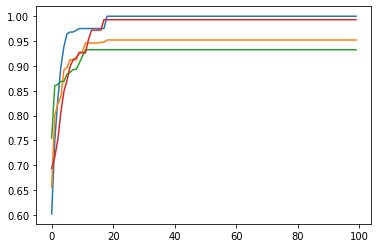

In [11]:
for k in range(4):
    plt.plot(np.mean(np.array(ress[k]),axis=0))

In [10]:
np.array(ress[0])

(20, 100)